# Gender Recognition by Voice


   **meanfreq:** mean frequency (in kHz)
   
   **sd:** standard deviation of frequency
   
   **median:** median frequency (in kHz)
   
   **Q25:** first quantile (in kHz)
   
   **Q75:** third quantile (in kHz)
   
   **IQR:** interquantile range (in kHz)
   
   **skew:** skewness (see note in specprop description)
   
   **kurt:** kurtosis (see note in specprop description)
   
   **sp.ent:** spectral entropy
   
   **sfm:** spectral flatness
   
   **mode:** mode frequency
   
   **centroid:** frequency centroid (see specprop)
   
   **peakf:** peak frequency (frequency with highest energy)
   
   **meanfun:** average of fundamental frequency measured across acoustic signal
   
   **minfun:** minimum fundamental frequency measured across acoustic signal
   
   **maxfun:** maximum fundamental frequency measured across acoustic signal
   
   **meandom:** average of dominant frequency measured across acoustic signal
   
   **mindom:** minimum of dominant frequency measured across acoustic signal
   
   **maxdom:** maximum of dominant frequency measured across acoustic signal
   
   **dfrange:** range of dominant frequency measured across acoustic signal
   
   **modindx:** modulation index.
   
   Calculated as the accumulated absolute difference between adjacent measurements of fundamental fequencies divided by the frequency range. 
   
   **label:** male or female


In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 
# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

import keras
from keras import backend as K

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

Using TensorFlow backend.


In [2]:
train = pd.read_csv("voice.csv")

In [3]:
df = train.copy()

In [4]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [5]:
df.shape

(3168, 21)

In [6]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [7]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [8]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

**No imputations needed.**

In [9]:
temp = []
for i in df.label:
    if i == 'male':
        temp.append(1)
    else:
        temp.append(0)
df['label'] = temp

** 0 - FEMALE , 1 - MALE** 

In [10]:
df.label.value_counts()

1    1584
0    1584
Name: label, dtype: int64

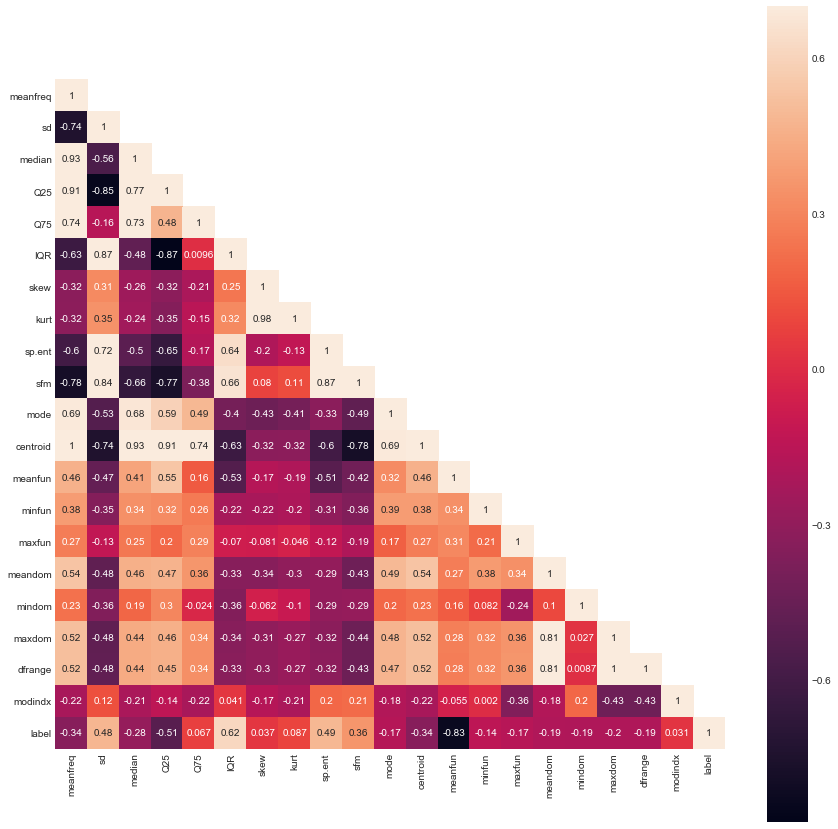

In [11]:
correlation_map = df.corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

**This clearly shows that Q25 and meanfun highly correlates with label inversely which is our are target variable.**

**Some other variables are sd , IQR , sp.ent that correlates directly with label.**

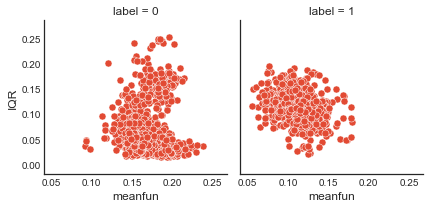

In [12]:
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(df, col="label", palette="Set1")
g = (g.map(plt.scatter, "meanfun", "IQR", **kws).add_legend())

** This shows that a MALES have comparatively LOW IQR and LOW meanfun and their respective mappings as well when compared to FEMALES.**

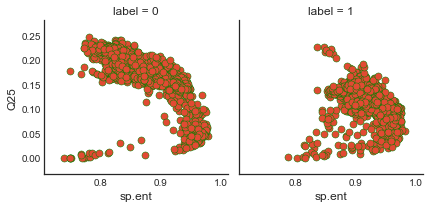

In [13]:
kws = dict(s=50, linewidth=.5, edgecolor="g")
g = sns.FacetGrid(df, col="label", palette="Pal")
g = (g.map(plt.scatter, "sp.ent", "Q25", **kws).add_legend())

**The above plot depicts the outliers and that we can actually see the instances of the dataframe that are filled with LOW sp.ent and a HIGH Q25 are labeled as FEMALE whereas the males fail to show the above stated trend.**

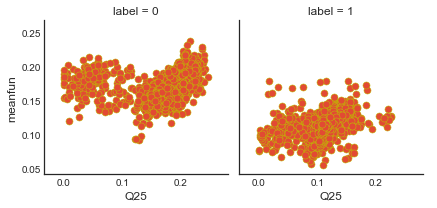

In [14]:
kws = dict(s=50, linewidth=.5, edgecolor="y")
g = sns.FacetGrid(df, col="label")
g = (g.map(plt.scatter, "Q25", "meanfun", **kws).add_legend())

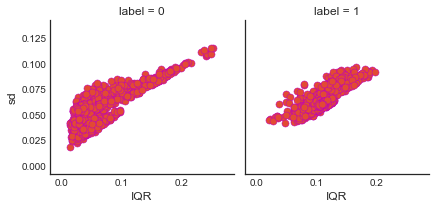

In [15]:
kws = dict(s=50, linewidth=.5, edgecolor="m")
g = sns.FacetGrid(df, col="label", palette="Set1")
g = (g.map(plt.scatter, "IQR", "sd", **kws).add_legend())

**The below plots will clearly give you the idea of where the points have been accumulated greater than others or their densities.**

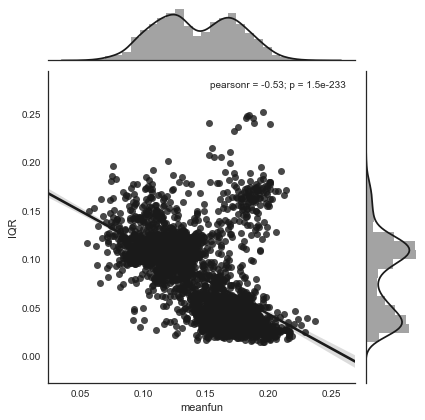

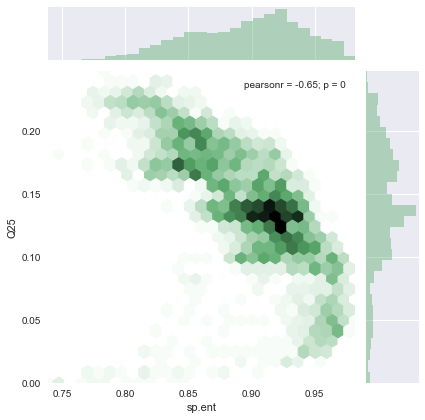

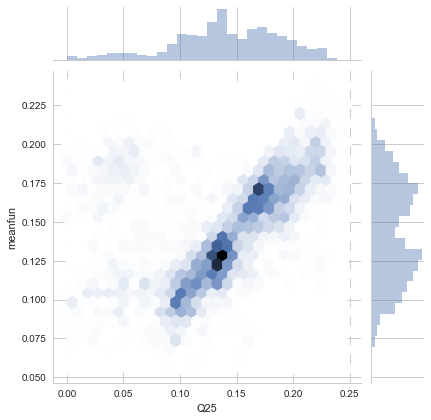

In [16]:
sns.set(style="white", color_codes=True)
sns.jointplot("meanfun", "IQR", data=df, kind="reg" , color='k')
sns.set(style="darkgrid", color_codes=True)
sns.jointplot("sp.ent", "Q25", data=df, kind="hex" , color='g')
sns.set(style="whitegrid", color_codes=True)
g = (sns.jointplot(df.Q25 , df.meanfun , kind="hex", stat_func=None).set_axis_labels("Q25", "meanfun"))

**Combining above all to have one last glance at all important features**

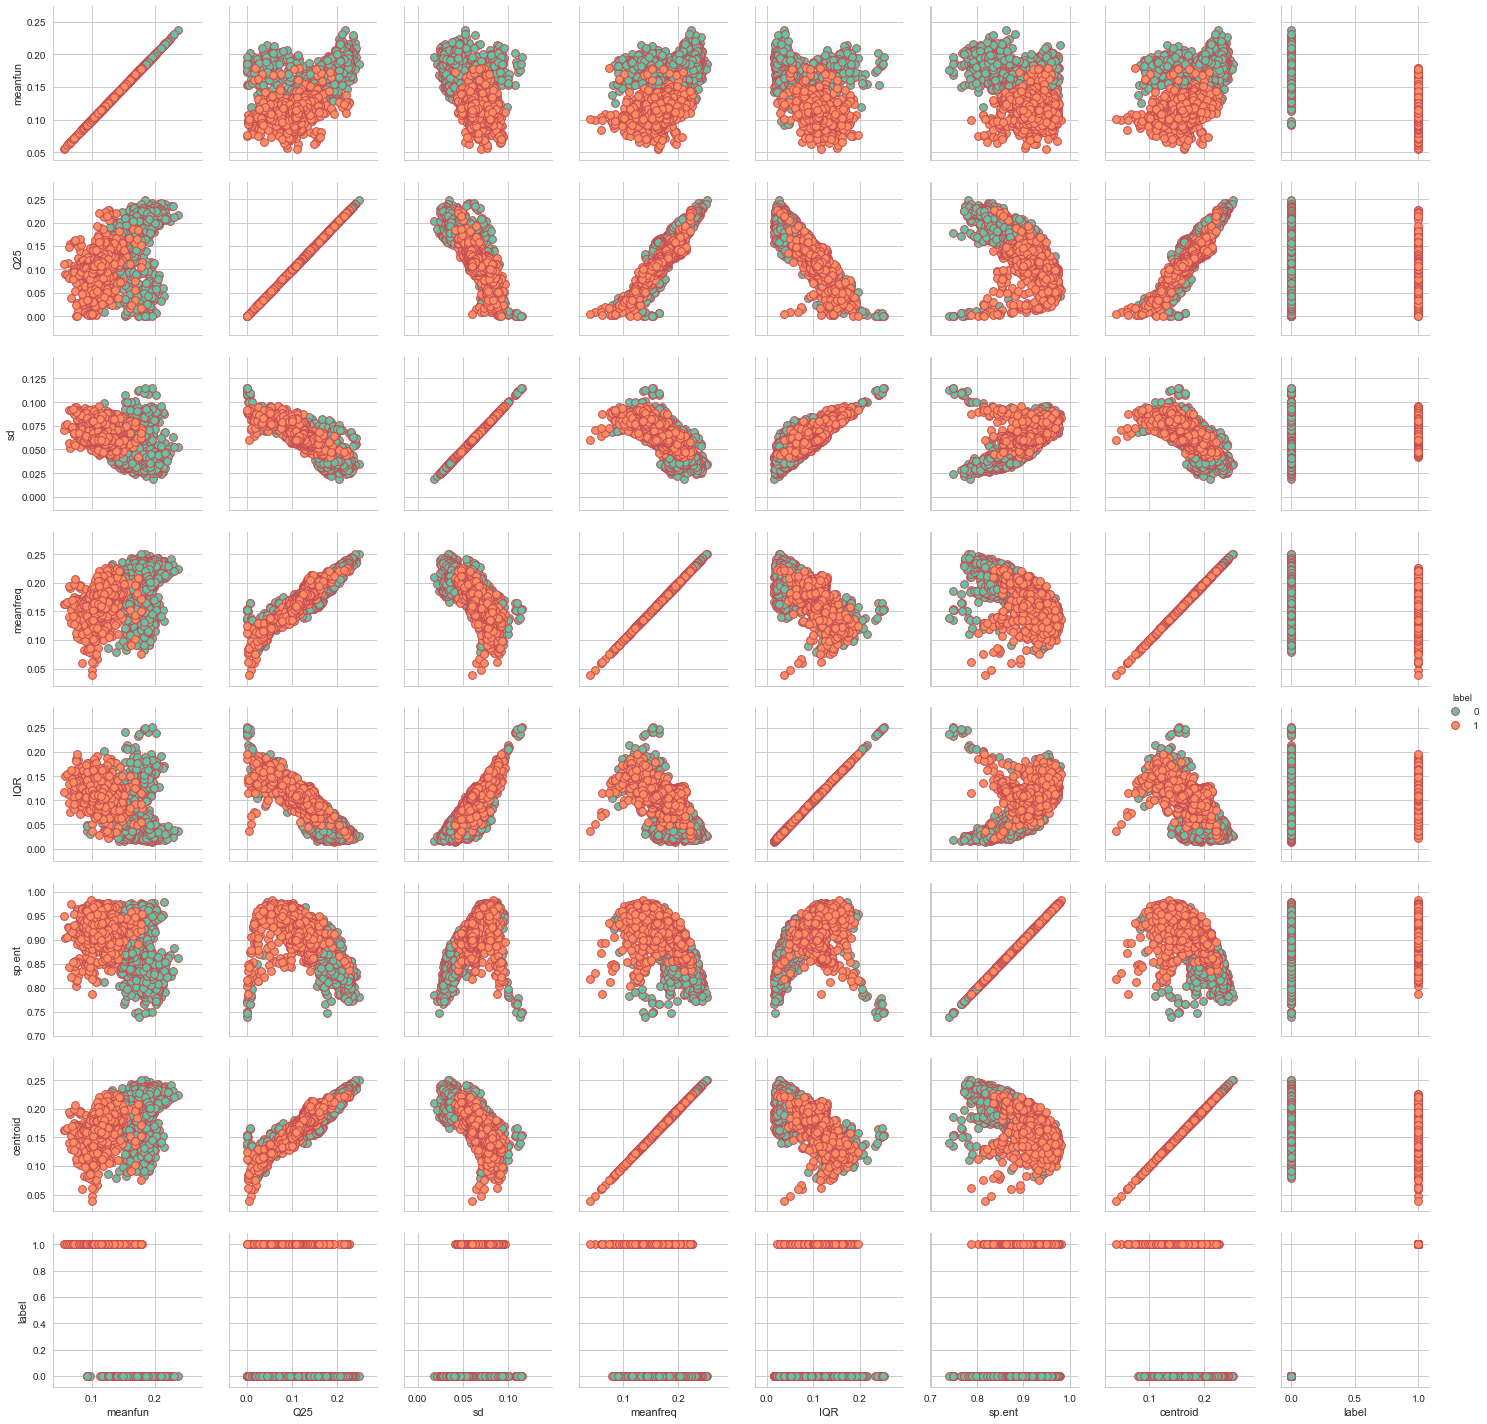

In [17]:
g = sns.PairGrid(df[["meanfun" , "Q25" , "sd" , "meanfreq" , "IQR" , "sp.ent" , "centroid", "label"]] , palette="Set2" , hue = "label")
g = g.map(plt.scatter, linewidths=1, edgecolor="r", s=60)
g = g.add_legend()

**Though we don't have any values to impute , but if we have to ,then we have to go with the inferences from the plots above to impute the more accurate value into their respective columns**

In [18]:
from sklearn import svm
X = df[df.columns[0:20]]
y = df.label
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)
clf = svm.SVC()
clf.fit(X_train , y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
pred = clf.predict(X_test)

In [20]:
print(accuracy_score(y_test, pred))

0.739747634069


**Non crossvalidated accuracy without any standardization or normalization is 0.7570 which is very less. **

**Now , Standardizing the data for greater performance by the model.**

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

In [107]:
X = df[: , 0:20]
y = df[: , 20]
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)
clf = svm.SVC()
clf.fit(X_train , y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [108]:
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.984227129338


**The above accuracy clearly depicts that how much fruitful is doing the standardization for this dataframe.**

**It achieves a pretty much good accuracy of 0.9842 only after standardization i.e. making the mean of the each and every panda series in the dataframe as 0 , variance as 1.**

## Now , tuning the parameters and trying different models.

In [24]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC()
scores = cross_val_score(clf , X , y , cv=10)
scores

array([ 0.93396226,  0.95597484,  0.96855346,  0.9591195 ,  0.96835443,
        0.99683544,  0.98734177,  0.98101266,  0.91455696,  0.99367089])

**Mean cross-validation score for default parameters.**

In [109]:
scores.mean()

0.96593822147918151

**Different cross-validation scores with default parameters of SVC** 

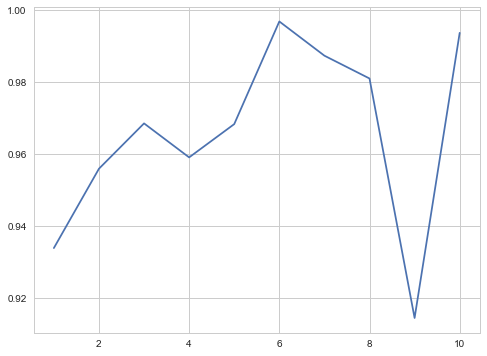

In [46]:
temp = np.arange(11)[1 : 11]
plt.plot(temp , scores)
plt.show()

In [121]:
from sklearn.model_selection import GridSearchCV
model = svm.SVC()
param_grid = {
"C" : np.linspace(0.01,1,10)
}
grid = GridSearchCV( model , param_grid , cv = 10 , scoring = "accuracy")
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.01,  0.12,  0.23,  0.34,  0.45,  0.56,  0.67,  0.78,  0.89,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

**For tuning only C , we got a rise in the mean cross-validation than before.**

In [122]:
grid.best_score_

0.9674873737373737

In [123]:
grid.best_params_

{'C': 0.56000000000000005}

In [124]:
grid.grid_scores_

C:\Users\RV\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.88668, std: 0.08974, params: {'C': 0.01},
 mean: 0.96086, std: 0.02684, params: {'C': 0.12},
 mean: 0.96496, std: 0.02522, params: {'C': 0.23000000000000001},
 mean: 0.96591, std: 0.02533, params: {'C': 0.34000000000000002},
 mean: 0.96717, std: 0.02373, params: {'C': 0.45000000000000001},
 mean: 0.96749, std: 0.02418, params: {'C': 0.56000000000000005},
 mean: 0.96717, std: 0.02476, params: {'C': 0.67000000000000004},
 mean: 0.96749, std: 0.02552, params: {'C': 0.78000000000000003},
 mean: 0.96622, std: 0.02504, params: {'C': 0.89000000000000001},
 mean: 0.96591, std: 0.02496, params: {'C': 1.0}]

**Cross-validation scores for each value of C**

In [125]:
for i in grid.grid_scores_:
    print(i[2])

[ 0.69496855  0.89622642  0.78301887  0.91194969  0.93670886  0.97151899
  0.99050633  0.97468354  0.82278481  0.88607595]
[ 0.91823899  0.94339623  0.95597484  0.94339623  0.96835443  0.99683544
  0.99050633  0.9778481   0.92405063  0.99050633]
[ 0.9245283   0.94968553  0.96226415  0.95283019  0.96835443  1.
  0.99050633  0.98417722  0.92721519  0.99050633]
[ 0.92767296  0.95283019  0.96540881  0.9591195   0.96835443  1.
  0.99050633  0.98417722  0.92088608  0.99050633]
[ 0.93081761  0.95597484  0.96540881  0.9591195   0.96835443  1.
  0.99050633  0.98101266  0.92721519  0.99367089]
[ 0.93081761  0.95597484  0.96855346  0.96226415  0.96835443  1.
  0.99050633  0.98101266  0.92405063  0.99367089]
[ 0.93081761  0.95597484  0.96855346  0.96226415  0.96835443  1.
  0.99050633  0.98101266  0.92088608  0.99367089]
[ 0.93081761  0.95597484  0.96855346  0.96540881  0.96835443  1.
  0.99050633  0.98417722  0.91772152  0.99367089]
[ 0.93081761  0.95597484  0.96855346  0.9591195   0.96835443  0.

C:\Users\RV\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


**Variation of mean cross-validation scores wrt the change in C parameter alone. Notice the shoot in curve**

C:\Users\RV\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


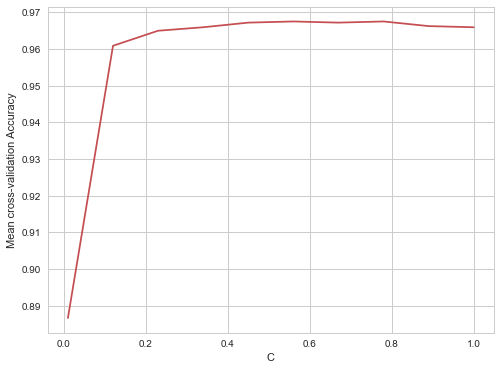

In [126]:
gridscores = []
for i in grid.grid_scores_:
    gridscores.append(i[1])
    
plt.xlabel('C')
plt.ylabel('Mean cross-validation Accuracy')
plt.plot(np.linspace(0.01,1,10) , gridscores , 'r')
plt.show()

In [133]:
from sklearn.model_selection import GridSearchCV
model = svm.SVC()
param_grid = {
"gamma" : [0.0001,0.001,0.01,0.1,1,10,100,300,600]
}
grid = GridSearchCV( model , param_grid , cv = 10 , scoring = "accuracy")
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 300, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

**Again, with tuning of only gamma gave us the best of the mean cross-validation scores than the two cases before.**

In [134]:
grid.best_score_

0.96811868686868685

In [135]:
grid.best_params_

{'gamma': 0.01}

In [136]:
grid.grid_scores_

C:\Users\RV\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.88763, std: 0.09771, params: {'gamma': 0.0001},
 mean: 0.95518, std: 0.03724, params: {'gamma': 0.001},
 mean: 0.96812, std: 0.02470, params: {'gamma': 0.01},
 mean: 0.96307, std: 0.02489, params: {'gamma': 0.1},
 mean: 0.90720, std: 0.07086, params: {'gamma': 1},
 mean: 0.59533, std: 0.10472, params: {'gamma': 10},
 mean: 0.50000, std: 0.00000, params: {'gamma': 100},
 mean: 0.50000, std: 0.00000, params: {'gamma': 300},
 mean: 0.50000, std: 0.00000, params: {'gamma': 600}]

**The plot at the below shows that how Mean cross-validation Accuracy decreases with increase in gamma parameter.**

C:\Users\RV\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


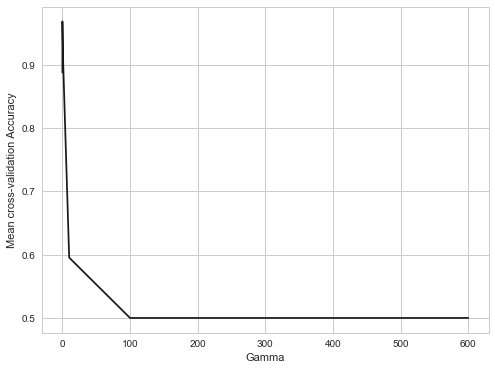

In [137]:
gridscores = []
for i in grid.grid_scores_:
    gridscores.append(i[1])
    
plt.xlabel('Gamma')
plt.ylabel('Mean cross-validation Accuracy')
plt.plot([0.0001,0.001,0.01,0.1,1,10,100,300,600] , gridscores , 'k')
plt.show()

In [139]:
model = svm.SVC()
param_grid = {
"C" : [0.50 , 0.55 , 0.59 , 0.63] ,
"gamma" : [0.005, 0.008, 0.010, 0.012 , 0.015]
}
grid = GridSearchCV( model , param_grid , cv = 10 , scoring = "accuracy")
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 0.55, 0.59, 0.63], 'gamma': [0.005, 0.008, 0.01, 0.012, 0.015]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

**The so far best score with SVC is 0.9681 with rbf kernel.**

In [140]:
grid.best_score_

0.96811868686868685

In [141]:
grid.best_params_

{'C': 0.63, 'gamma': 0.015}

In [142]:
model = svm.SVC(kernel='linear')
param_grid = {
"C" : [0.50 , 0.55 , 0.59 , 0.63] ,
"gamma" : [0.005, 0.008, 0.010, 0.012 , 0.015]
}
grid = GridSearchCV( model , param_grid , cv = 10 , scoring = "accuracy")
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 0.55, 0.59, 0.63], 'gamma': [0.005, 0.008, 0.01, 0.012, 0.015]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

**With linear kernel we got 0.96969 or ~97% accuracy.**

In [143]:
grid.best_score_

0.96969696969696972

In [144]:
grid.best_params_

{'C': 0.63, 'gamma': 0.005}

**Still tuning in proximity gave 0.9700481 for C = 0.1 and gamma = 0.447**

In [176]:
model = svm.SVC(kernel='linear',C=0.1 , gamma=0.447)
scores = cross_val_score(model , X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.970048164955


In [281]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 61 , max_depth = 37)
scores = cross_val_score(model , X , y , cv=10)
scores

array([ 0.93396226,  0.94968553,  0.98427673,  0.95283019,  0.96835443,
        0.99367089,  0.99367089,  0.98734177,  0.92405063,  0.99367089])

In [282]:
scores.mean()

0.9681514210652018

**RandomForestClassifier is also giving accuracy close to SVC.**

In [286]:
model.fit(X , y)
print(model.feature_importances_)

[ 0.01773058  0.07865834  0.01457807  0.10890634  0.01180795  0.1653965
  0.01102912  0.00899826  0.03833908  0.02437783  0.01117969  0.02065682
  0.43477489  0.00973164  0.0051461   0.00724048  0.0044942   0.01092525
  0.00926586  0.00676299]


**Feature Importance**

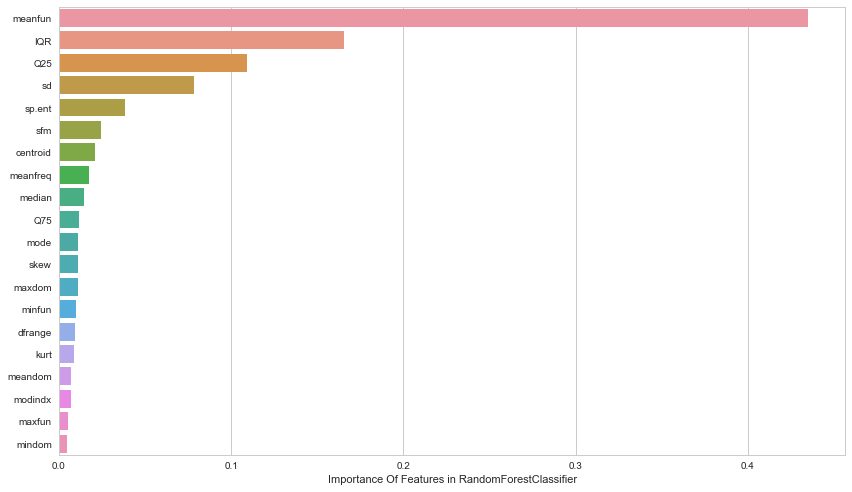

In [293]:
ranks = np.argsort(-model.feature_importances_)
f, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=model.feature_importances_[ranks], y=train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features in RandomForestClassifier")
plt.tight_layout()
plt.show()

**With Default parameters GradientBoostingClassifier is giving 0.9681.**

In [303]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
scores = cross_val_score(model, X , y , cv=5)
scores

array([ 0.9384858 ,  0.97634069,  0.97791798,  0.9873817 ,  0.96044304])

In [305]:
scores.mean()

0.96811384418799662

**With Default parameters XGBClassifier is giving 0.9690.**

In [306]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
scores = cross_val_score(model, X , y , cv=10)
scores

array([ 0.93396226,  0.95283019,  0.98427673,  0.96226415,  0.96835443,
        0.99367089,  0.99050633,  0.98417722,  0.92721519,  0.99367089])

In [307]:
scores.mean()

0.96909282700421928

In [329]:
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)
xgb.fit(X_train , y_train)
pred = xgb.predict(X_test)

In [330]:
print(accuracy_score(y_test , pred))

0.993690851735


## XGBClassifier is able to give the whooping accuracy of 99.36 %

**But the above accuracy is not cross-validated.**

**The best cross-validated score obtained so far is by Support Vector Machines and is 97.004 %.**

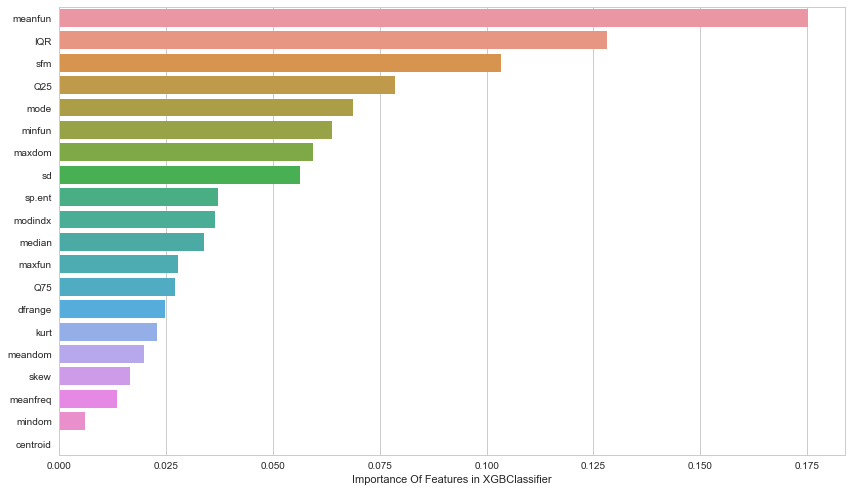

In [334]:
ranks = np.argsort(-xgb.feature_importances_)
f, ax = plt.subplots(figsize=(12, 7))

sns.barplot(x=xgb.feature_importances_[ranks], y=train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features in XGBClassifier")
plt.tight_layout()
plt.show()